In [1]:
# Importing all necesary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [2]:
# Loading our dataset
df = pd.read_csv('uganda_traffic_forecasting.csv')

# Previewing the dataset
print(df.shape)
display(df.head())


(1538, 11)


,timestamp,location_id,vehicle_count,avg_speed,weather,day_of_week,is_holiday,event,sensor_status,road_condition,target_congestion_level
0,2023-01-01 03:00:00,ENT002,23.0,40.72036861283745,Clear,Thursday,0.0,Parade,FAIL,Good,0.0
1,2023-01-01 03:15:00,GUL004,15.0,37.87791030098848,Rainy,Tuesday,0.0,Parade,FAIL,Poor,1.0
2,2023-01-01 03:30:00,GUL004,21.0,30.480815399777644,Clear,Saturday,1.0,Marathon,OK,Moderate,2.0
3,2023-01-01 03:45:00,MBR003,25.0,40.774805185188626,Rainy,Monday,0.0,NaN,UNKNOWN,???,0.0
4,2023-01-01 04:00:00,GUL004,15.0,42.57752540142751,Snowy,Friday,0.0,Marathon,OK,Moderate,1.0


In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   timestamp                1537 non-null   object
 1   location_id              1534 non-null   object
 2   vehicle_count            1536 non-null   object
 3   avg_speed                1537 non-null   object
 4   weather                  1533 non-null   object
 5   day_of_week              1533 non-null   object
 6   is_holiday               1534 non-null   object
 7   event                    1155 non-null   object
 8   sensor_status            1538 non-null   object
 9   road_condition           1536 non-null   object
 10  target_congestion_level  1537 non-null   object
dtypes: object(11)
memory usage: 132.3+ KB


None

In [4]:
# Replacing the string '???' with NumPy's Not a Number (NaN)
df.replace('???', np.nan, inplace=True)

print("Replaced all '???' strings with np.nan.")

Replaced all '???' strings with np.nan.


In [5]:
# Converting 'timestamp' to a proper datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Defining which columns should be numbers
numeric_cols = ['vehicle_count', 'avg_speed', 'is_holiday', 'target_congestion_level']

# Converting the numeric columns, turning any conversion errors into NaN
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Converted columns to their correct data types.")
display(df.info())

Converted columns to their correct data types.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   timestamp                1533 non-null   datetime64[ns]
 1   location_id              1529 non-null   object        
 2   vehicle_count            1528 non-null   float64       
 3   avg_speed                1533 non-null   float64       
 4   weather                  1529 non-null   object        
 5   day_of_week              1533 non-null   object        
 6   is_holiday               1527 non-null   float64       
 7   event                    1147 non-null   object        
 8   sensor_status            1534 non-null   object        
 9   road_condition           1533 non-null   object        
 10  target_congestion_level  1532 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memo

None

In [6]:
# Checking for duplicate rows before removal
initial_duplicates = df.duplicated().sum()
print(f"Found {initial_duplicates} duplicate rows.")


Found 72 duplicate rows.


In [7]:
# Removing duplicate rows
df.drop_duplicates(inplace=True)
print(f"Removed {initial_duplicates} duplicate rows.")

# Verifing that duplicates are gone
remaining_duplicates = df.duplicated().sum()
print(f"Remaining duplicates: {remaining_duplicates}")

Removed 72 duplicate rows.
Remaining duplicates: 0


In [8]:
print("Missing values per column:\n")
print(df.isnull().sum())

Missing values per column:

timestamp                    5
location_id                  8
vehicle_count               10
avg_speed                    5
weather                      9
day_of_week                  5
is_holiday                  11
event                      376
sensor_status                4
road_condition               5
target_congestion_level      6
dtype: int64


In [9]:
#Fill missing values 

# fill with the categorical columns with the mode,
for col in ['location_id', 'weather', 'day_of_week', 'event', 'road_condition', 'sensor_status']:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

# filling numerical columns with the median /mean
df['vehicle_count'] = df['vehicle_count'].fillna(df['vehicle_count'].median())
df['avg_speed'] = df['avg_speed'].fillna(df['avg_speed'].mean())
df['is_holiday'] = df['is_holiday'].fillna(0)  # Assume not a holiday if unknown
df['target_congestion_level'] = df['target_congestion_level'].fillna(df['target_congestion_level'].median())

# Dropping any rows where the timestamp could not be converted
df.dropna(subset=['timestamp'], inplace=True)

print("Handled all missing values.")
print("Missing values per column:\n", df.isnull().sum())
print(df.shape)


Handled all missing values.
Missing values per column:
 timestamp                  0
location_id                0
vehicle_count              0
avg_speed                  0
weather                    0
day_of_week                0
is_holiday                 0
event                      0
sensor_status              0
road_condition             0
target_congestion_level    0
dtype: int64
(1461, 11)


 Detecting outliers in 'vehicle_count' and 'avg_speed'...


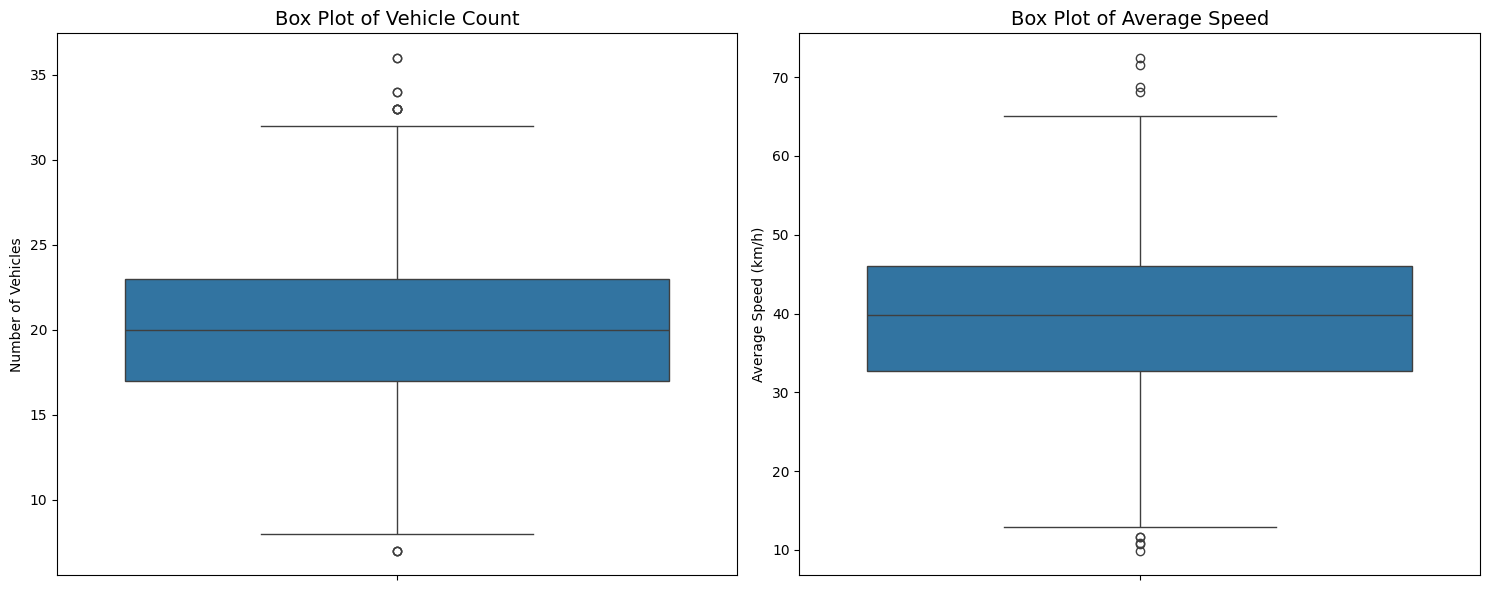


--- Analysis for 'vehicle_count' ---
Lower Bound: 8.00
Upper Bound: 32.00
Number of outliers detected: 12

--- Analysis for 'avg_speed' ---
Lower Bound: 12.66
Upper Bound: 66.06
Number of outliers detected: 9


In [10]:
# checking for outliers using a box plot
import matplotlib.pyplot as plt
import seaborn as sns

print(" Detecting outliers in 'vehicle_count' and 'avg_speed'...")

# Creating a figure to hold the subplots
plt.figure(figsize=(15, 6))

# Box plot for 'vehicle_count'
plt.subplot(1, 2, 1)
sns.boxplot(y=df['vehicle_count'])
plt.title('Box Plot of Vehicle Count', fontsize=14)
plt.ylabel('Number of Vehicles')

# Box plot for 'avg_speed'
plt.subplot(1, 2, 2)
sns.boxplot(y=df['avg_speed'])
plt.title('Box Plot of Average Speed', fontsize=14)
plt.ylabel('Average Speed (km/h)')

plt.tight_layout()
plt.show()

# Programmatic Detection using IQR 
for col in ['vehicle_count', 'avg_speed']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"\n--- Analysis for '{col}' ---")
    print(f"Lower Bound: {lower_bound:.2f}")
    print(f"Upper Bound: {upper_bound:.2f}")
    print(f"Number of outliers detected: {len(outliers)}")

Handling outliers by capping...
Outliers have been capped.

Verifying that outliers have been handled (We used boxplots)


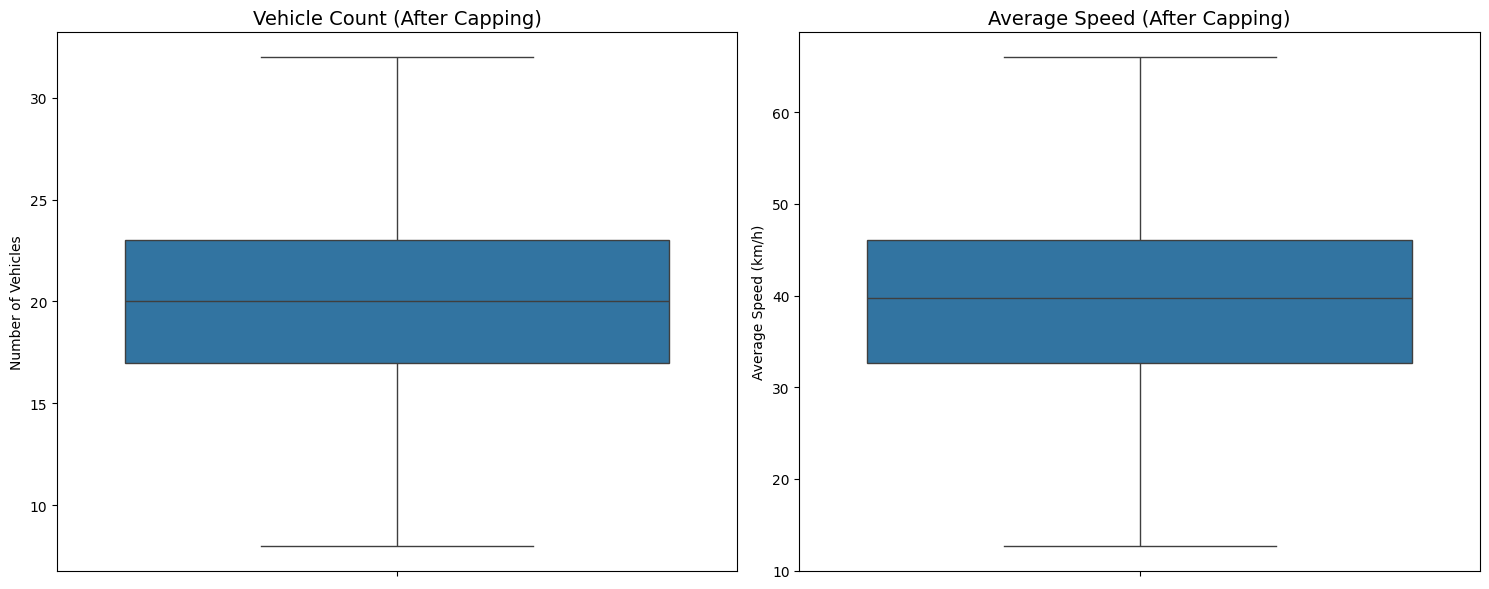

In [11]:
print("Handling outliers by capping...")

# Looping through the columns again to apply capping
for col in ['vehicle_count', 'avg_speed']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping the outliers
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])

print("Outliers have been capped.")

# Verification 
print("\nVerifying that outliers have been handled (We used boxplots)")

plt.figure(figsize=(15, 6))

# Box plot for 'vehicle_count' after capping
plt.subplot(1, 2, 1)
sns.boxplot(y=df['vehicle_count'])
plt.title('Vehicle Count (After Capping)', fontsize=14)
plt.ylabel('Number of Vehicles')

#Box plot for 'avg_speed' after capping
plt.subplot(1, 2, 2)
sns.boxplot(y=df['avg_speed'])
plt.title('Average Speed (After Capping)', fontsize=14)
plt.ylabel('Average Speed (km/h)')

plt.tight_layout()
plt.show()

In [12]:
# Verifing that the entire cleaning process worked
print("--- Final Cleaned Data Info ---")
df.info()



--- Final Cleaned Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 1461 entries, 0 to 1520
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   timestamp                1461 non-null   datetime64[ns]
 1   location_id              1461 non-null   object        
 2   vehicle_count            1461 non-null   float64       
 3   avg_speed                1461 non-null   float64       
 4   weather                  1461 non-null   object        
 5   day_of_week              1461 non-null   object        
 6   is_holiday               1461 non-null   float64       
 7   event                    1461 non-null   object        
 8   sensor_status            1461 non-null   object        
 9   road_condition           1461 non-null   object        
 10  target_congestion_level  1461 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 137.0+ KB


In [13]:
print("\n--- Final Missing Values Check ---")

print(df.isnull().sum())



--- Final Missing Values Check ---
timestamp                  0
location_id                0
vehicle_count              0
avg_speed                  0
weather                    0
day_of_week                0
is_holiday                 0
event                      0
sensor_status              0
road_condition             0
target_congestion_level    0
dtype: int64


In [14]:
print("\nData cleaning complete. ")
display(df.head())


Data cleaning complete. 


,timestamp,location_id,vehicle_count,avg_speed,weather,day_of_week,is_holiday,event,sensor_status,road_condition,target_congestion_level
0,2023-01-01 03:00:00,ENT002,23.0,40.720369,Clear,Thursday,0.0,Parade,FAIL,Good,0.0
1,2023-01-01 03:15:00,GUL004,15.0,37.877910,Rainy,Tuesday,0.0,Parade,FAIL,Poor,1.0
2,2023-01-01 03:30:00,GUL004,21.0,30.480815,Clear,Saturday,1.0,Marathon,OK,Moderate,2.0
3,2023-01-01 03:45:00,MBR003,25.0,40.774805,Rainy,Monday,0.0,Accident,UNKNOWN,Good,0.0
4,2023-01-01 04:00:00,GUL004,15.0,42.577525,Snowy,Friday,0.0,Marathon,OK,Moderate,1.0


In [15]:
# Saving the final, cleaned DataFrame to a new CSV file.

df.to_csv('df_cleaned.csv', index=False)

print("DataFrame successfully saved to 'df_cleaned.csv'")

DataFrame successfully saved to 'df_cleaned.csv'


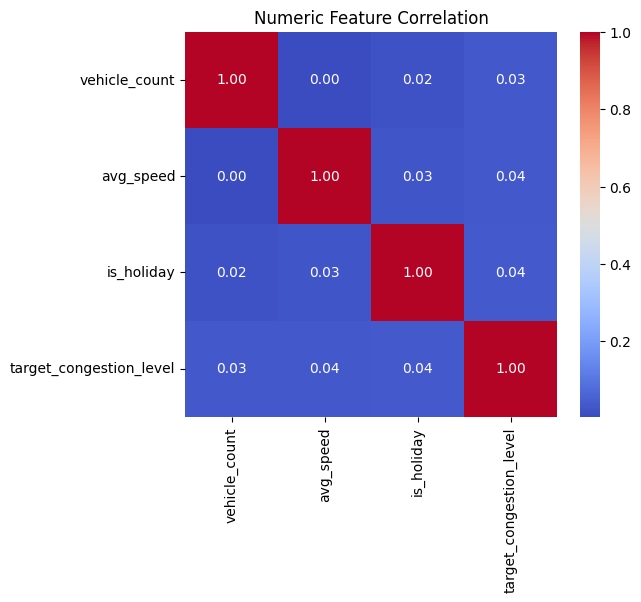

In [16]:
# Correlation of numeric features
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Numeric Feature Correlation")
plt.show()


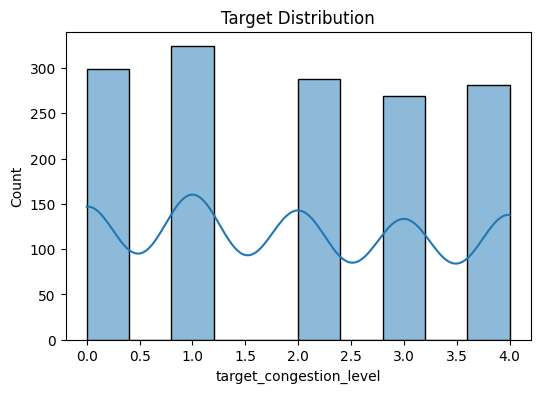

In [17]:
# Distribution of target
plt.figure(figsize=(6,4))
sns.histplot(df['target_congestion_level'], bins=10, kde=True)
plt.title("Target Distribution")
plt.show()

In [ ]:
# # BASELINE
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np

# # 1. Defining baseline features (no engineered features)
# base_features = ['vehicle_count', 'avg_speed', 'is_holiday', 'weather', 'road_condition', 'location_id']

# df_base= pd.read_csv("df_cleaned.csv")

# # Dropping rows with missing values in relevant columns (including target)
# df_base = df_base.dropna(subset=base_features + ['target_congestion_level'])

# # One-hot encoding categorical variables
# X_base = pd.get_dummies(df_base[base_features], columns=['weather', 'road_condition', 'location_id'], drop_first=True)

# # Defining the target (continuous regression)
# y_base = df_base['target_congestion_level']

# # TRAINING AND TESTING SPLIT
# Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

# # Initializing and training the model
# rf_base = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42)
# rf_base.fit(Xb_train, yb_train)



RandomForestRegressor(max_depth=12, n_estimators=200, random_state=42)

In [20]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split


# # loading our csv file with engineered features
# df_feat = pd.read_csv("df_feat.csv")

# # Checking if target exists
# if 'target_congestion_level' not in df_feat.columns:
#     raise ValueError("Column 'target_congestion_level' is missing in df_feat!")

# # Dropping rows with missing values
# df_feat = df_feat.dropna().reset_index(drop=True)

# # Separating target and drop unused columns ---
# y = df_feat['target_congestion_level']
# df_feat = df_feat.drop(columns=['target_congestion_level', 'timestamp'], errors='ignore')

# # Encoding categorical features
# for col in df_feat.select_dtypes(include=['object', 'category']).columns:
#     df_feat[col] = df_feat[col].astype(str)

# categorical_cols = df_feat.select_dtypes(include='object').columns.tolist()
# df_model = pd.get_dummies(df_feat, columns=categorical_cols, drop_first=True)

# X = df_model

# # Time-based train-test split (80/20)
# split_index = int(len(X) * 0.8)
# X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
# y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# # Training the model
# rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# rf_reg.fit(X_train, y_train)

# # Predicting on the test set
# y_pred = rf_reg.predict(X_test)

# # Evaluation metrics
# mae_baseline = mean_absolute_error(y_test, y_pred)
# mse_baseline = mean_squared_error(y_test, y_pred)
# rmse_baseline = np.sqrt(mse_baseline)
# r2_baseline = r2_score(y_test, y_pred)

# print("\n--- Model Performance (With Engineered Features) ---")
# print(f"Mean Absolute Error (MAE): {mae_baseline:.4f}")
# print(f"Mean Squared Error (MSE): {mse_baseline:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse_baseline:.4f}")
# print(f"R-squared (R²): {r2_baseline:.4f}")



In [20]:
# BASELINE MODEL
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Defining baseline model (no engineered features)
base_features = ['vehicle_count', 'avg_speed', 'is_holiday', 'weather', 'road_condition', 'location_id']

df_base= pd.read_csv("df_cleaned.csv")

# Dropping rows with missing values in relevant columns (including target)
df_base = df_base.dropna(subset=base_features + ['target_congestion_level'])

# One-hot encoding categorical variables
X_base = pd.get_dummies(df_base[base_features], columns=['weather', 'road_condition', 'location_id'], drop_first=True)

# Defining the target (continuous regression)
y_base = df_base['target_congestion_level']

# TRAINING AND TESTING SPLIT
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

# Initializing and training the model
rf_base = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42)
rf_base.fit(Xb_train, yb_train)



RandomForestRegressor(max_depth=12, n_estimators=200, random_state=42)

In [21]:
# Predictions
yb_pred = rf_base.predict(Xb_test)

# --- Evaluating Metrics ---
mae_baseline = mean_absolute_error(yb_test, yb_pred)
mse_baseline = mean_squared_error(yb_test, yb_pred)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(yb_test, yb_pred)

# --- Printing Model Performance ---
print("\n--- Model Performance (Regression Metrics) ---")
print(f"Mean Absolute Error (MAE): {mae_baseline:.4f}")
print(f"Mean Squared Error (MSE): {mse_baseline:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_baseline:.4f}")
print(f"R-squared (R²): {r2_baseline:.4f}")


--- Model Performance (Regression Metrics) ---
Mean Absolute Error (MAE): 1.2618
Mean Squared Error (MSE): 2.1672
Root Mean Squared Error (RMSE): 1.4721
R-squared (R²): -0.0667


In [22]:
import pandas as pd
import numpy as np

# --- Loading the Cleaned Dataset ---
df = pd.read_csv('df_cleaned.csv')
# Creating a dummy df_cleaned.csv for demonstration purposes
data = {
    'timestamp': pd.to_datetime(pd.date_range(start='2023-01-01', periods=100, freq='H')),
    'location_id': ['A']*50 + ['B']*50,
    'vehicle_count': np.random.randint(10, 100, 100),
    'avg_speed': np.random.uniform(20, 60, 100),
    'weather': np.random.choice(['Clear', 'Rainy'], 100),
    'road_condition': np.random.choice(['Good', 'Moderate'], 100),
    'is_holiday': np.random.choice([0, 1], 100),
    'event': np.random.choice(['None', 'Event'], 100),
    'target_congestion_level': np.random.uniform(0, 5, 100)
}
df = pd.DataFrame(data)


df['timestamp'] = pd.to_datetime(df['timestamp'])

df_feat = df.copy()


# Time-based features
df_feat['hour']       = df_feat['timestamp'].dt.hour
df_feat['weekday']    = df_feat['timestamp'].dt.dayofweek
df_feat['is_weekend'] = df_feat['weekday'].isin([5, 6]).astype(int)
df_feat['month']      = df_feat['timestamp'].dt.month

# Cyclical encoding for hour and month
df_feat['hour_sin']  = np.sin(2 * np.pi * df_feat['hour'] / 24)
df_feat['hour_cos']  = np.cos(2 * np.pi * df_feat['hour'] / 24)
df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)

# Traffic dynamics
df_feat['speed_per_vehicle'] = df_feat['avg_speed'] / (df_feat['vehicle_count'] + 1)
df_feat['veh_density']       = df_feat['vehicle_count'] / (df_feat['hour'] + 1)

# Interaction
df_feat['weather_road'] = df_feat['weather'] + '_' + df_feat['road_condition']


# The calculation MUST be grouped by location to prevent data leakage.
df_feat = df_feat.sort_values(['location_id', 'timestamp'])

# Lag features
df_feat['vehicle_count_lag1'] = df_feat.groupby('location_id')['vehicle_count'].shift(1)
df_feat['avg_speed_lag1']     = df_feat.groupby('location_id')['avg_speed'].shift(1)

# Rolling mean features
df_feat['vehicle_count_roll3'] = df_feat.groupby('location_id')['vehicle_count'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df_feat['avg_speed_roll3']     = df_feat.groupby('location_id')['avg_speed'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())


# ---More  Time-Based Features---
# Binned time of day
df_feat['time_of_day'] = pd.cut(df_feat['hour'], bins=[-1, 5, 9, 15, 19, 23], labels=['Night', 'Morning Rush', 'Midday', 'Afternoon Rush', 'Evening'])
# Week of the year
df_feat['week_of_year'] = df_feat['timestamp'].dt.isocalendar().week
# Indicator for a non-routine day
df_feat['is_special_day'] = ((df_feat['is_holiday'] == 1) | (df_feat['event'] != 'None')).astype(int)

# --- Cyclical---
# Cyclical representation of the day of the week
df_feat['day_of_week_sin'] = np.sin(2 * np.pi * df_feat['weekday'] / 7)
df_feat['day_of_week_cos'] = np.cos(2 * np.pi * df_feat['weekday'] / 7)

# --- Historical / Lag ---
# Previous congestion level
df_feat['congestion_lag1'] = df_feat.groupby('location_id')['target_congestion_level'].shift(1)
# Vehicle count from 2 steps ago
df_feat['vehicle_count_lag2'] = df_feat.groupby('location_id')['vehicle_count'].shift(2)
# Vehicle count from 3 steps ago
df_feat['vehicle_count_lag3'] = df_feat.groupby('location_id')['vehicle_count'].shift(3)

# --- Rolling Window Statistics ---
# Max vehicle count in the last 3 periods
df_feat['vehicle_count_roll_max3'] = df_feat.groupby('location_id')['vehicle_count'].transform(lambda x: x.rolling(window=3, min_periods=1).max())
# Min vehicle count in the last 3 periods
df_feat['vehicle_count_roll_min3'] = df_feat.groupby('location_id')['vehicle_count'].transform(lambda x: x.rolling(window=3, min_periods=1).min())
# Standard deviation of speed in the last 3 periods (volatility)
df_feat['avg_speed_roll_std3'] = df_feat.groupby('location_id')['avg_speed'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
# Rate of change in vehicle count
df_feat['traffic_velocity'] = df_feat['vehicle_count'] - df_feat['vehicle_count_lag1']

# --- Advanced Interaction ---
# Location and specific day of the week
df_feat['location_day'] = df_feat['location_id'] + '_' + df_feat['weekday'].astype(str)
# Location and time of day bin
df_feat['location_time_of_day'] = df_feat['location_id'] + '_' + df_feat['time_of_day'].astype(str)
# Time of day and road condition
df_feat['time_road_condition'] = df_feat['time_of_day'].astype(str) + '_' + df_feat['road_condition']


# Additional lags for the target variable
df_feat['congestion_lag2'] = df_feat.groupby('location_id')['target_congestion_level'].shift(2)
df_feat['congestion_lag3'] = df_feat.groupby('location_id')['target_congestion_level'].shift(3)

# Rolling statistics for the target variable (3-period trend and volatility)
df_feat['congestion_roll_mean3'] = df_feat.groupby('location_id')['target_congestion_level'].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
df_feat['congestion_roll_std3'] = df_feat.groupby('location_id')['target_congestion_level'].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).std())

#Expanding window mean for the target (captures long-term trend)
df_feat['congestion_expanding_mean'] = df_feat.groupby('location_id')['target_congestion_level'].transform(lambda x: x.shift(1).expanding(min_periods=1).mean())

#Rate of change of congestion
df_feat['congestion_velocity'] = df_feat['target_congestion_level'] - df_feat['congestion_lag1']


# --- Final Cleanup & Target ---
# Classifying target
df_feat['congestion_class'] = pd.cut(
    df_feat['target_congestion_level'],
    bins=[-1, 1.5, 3.5, 5],
    labels=[0, 1, 2]
).astype(int)

# Dropping rows with NA from lag/rolling features
df_feat = df_feat.dropna().reset_index(drop=True)

# Reviewing 
print("\nFeature engineering complete!")

# list of the new column names For absolute clarity
all_new_feature_names = [
    'time_of_day', 'week_of_year', 'is_special_day', 'day_of_week_sin',
    'day_of_week_cos', 'congestion_lag1', 'vehicle_count_lag2',
    'vehicle_count_lag3', 'vehicle_count_roll_max3', 'vehicle_count_roll_min3',
    'avg_speed_roll_std3', 'traffic_velocity', 'location_day',
    'location_time_of_day', 'time_road_condition',
    'congestion_lag2', 'congestion_lag3', 'congestion_roll_mean3',
    'congestion_roll_std3', 'congestion_expanding_mean', 'congestion_velocity'
]
print("\nList of All New Features Added:")
print(all_new_feature_names)

print("\nFinal DataFrame head (with all features):")
display(df_feat.head())

# Save all columns of the final DataFrame to CSV
df_feat.to_csv('df_feat.csv', index=False)


Feature engineering complete!

List of All New Features Added:
['time_of_day', 'week_of_year', 'is_special_day', 'day_of_week_sin', 'day_of_week_cos', 'congestion_lag1', 'vehicle_count_lag2', 'vehicle_count_lag3', 'vehicle_count_roll_max3', 'vehicle_count_roll_min3', 'avg_speed_roll_std3', 'traffic_velocity', 'location_day', 'location_time_of_day', 'time_road_condition', 'congestion_lag2', 'congestion_lag3', 'congestion_roll_mean3', 'congestion_roll_std3', 'congestion_expanding_mean', 'congestion_velocity']

Final DataFrame head (with all features):


/tmp/ipykernel_20752/1441702330.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.to_datetime(pd.date_range(start='2023-01-01', periods=100, freq='H')),


,timestamp,location_id,vehicle_count,avg_speed,weather,road_condition,is_holiday,event,target_congestion_level,hour,...,location_day,location_time_of_day,time_road_condition,congestion_lag2,congestion_lag3,congestion_roll_mean3,congestion_roll_std3,congestion_expanding_mean,congestion_velocity,congestion_class
0,2023-01-01 03:00:00,A,31,58.182861,Rainy,Moderate,1,None,0.097776,3,...,A_6,A_Night,Night_Moderate,1.929766,1.393420,1.589608,0.295740,1.589608,-1.347860,0
1,2023-01-01 04:00:00,A,55,28.216390,Rainy,Good,0,None,4.532782,4,...,A_6,A_Night,Night_Good,1.445637,1.929766,1.157726,0.949324,1.216650,4.435006,2
2,2023-01-01 05:00:00,A,66,40.309520,Rainy,Moderate,1,Event,1.382166,5,...,A_6,A_Night,Night_Moderate,0.097776,1.445637,2.025399,2.273634,1.879876,-3.150617,0
3,2023-01-01 06:00:00,A,14,22.222103,Rainy,Good,1,None,4.234612,6,...,A_6,A_Morning Rush,Morning Rush_Good,4.532782,0.097776,2.004242,2.282006,1.796925,2.852446,2
4,2023-01-01 07:00:00,A,58,40.045384,Clear,Good,0,None,1.866759,7,...,A_6,A_Morning Rush,Morning Rush_Good,1.382166,4.532782,3.383187,1.739336,2.145166,-2.367853,1


In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


#loading our csv file with engineered features 

df_feat = pd.read_csv("df_feat.csv")

# Checking if target exists
if 'target_congestion_level' not in df_feat.columns:
    raise ValueError("Column 'target_congestion_level' is missing in df_feat!")

#Dropping rows with missing values 
df_feat = df_feat.dropna().reset_index(drop=True)

#Separating target and drop unused columns ---
y = df_feat['target_congestion_level']
df_feat = df_feat.drop(columns=['target_congestion_level', 'timestamp'], errors='ignore')

#Encoding categorical features 
for col in df_feat.select_dtypes(include=['object', 'category']).columns:
    df_feat[col] = df_feat[col].astype(str)

categorical_cols = df_feat.select_dtypes(include='object').columns.tolist()
df_model = pd.get_dummies(df_feat, columns=categorical_cols, drop_first=True)

X = df_model

#Time-based train-test split (80/20) 
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

#Training the model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train)

#Evaluating our model
y_pred = rf_reg.predict(X_test)

# Calculating metrics
mae_engineered = mean_absolute_error(y_test, y_pred)
mse_engineered = mean_squared_error(y_test, y_pred)
rmse_engineered = np.sqrt(mse_engineered)
r2_engineered = r2_score(y_test, y_pred)

# Printing metrics
print("\n--- Model Performance ---")
print("Mean Absolute Error (MAE):")
print(mae_engineered)

print("Mean Squared Error (MSE):")
print(mse_engineered)

print("Root Mean Squared Error (RMSE):")
print(rmse_engineered)

print("R-squared (R²):")
print(r2_engineered)



--- Model Performance ---
Mean Absolute Error (MAE):
0.4796890802031278
Mean Squared Error (MSE):
0.282917730099553
Root Mean Squared Error (RMSE):
0.531900112896729
R-squared (R²):
0.9104110361416375


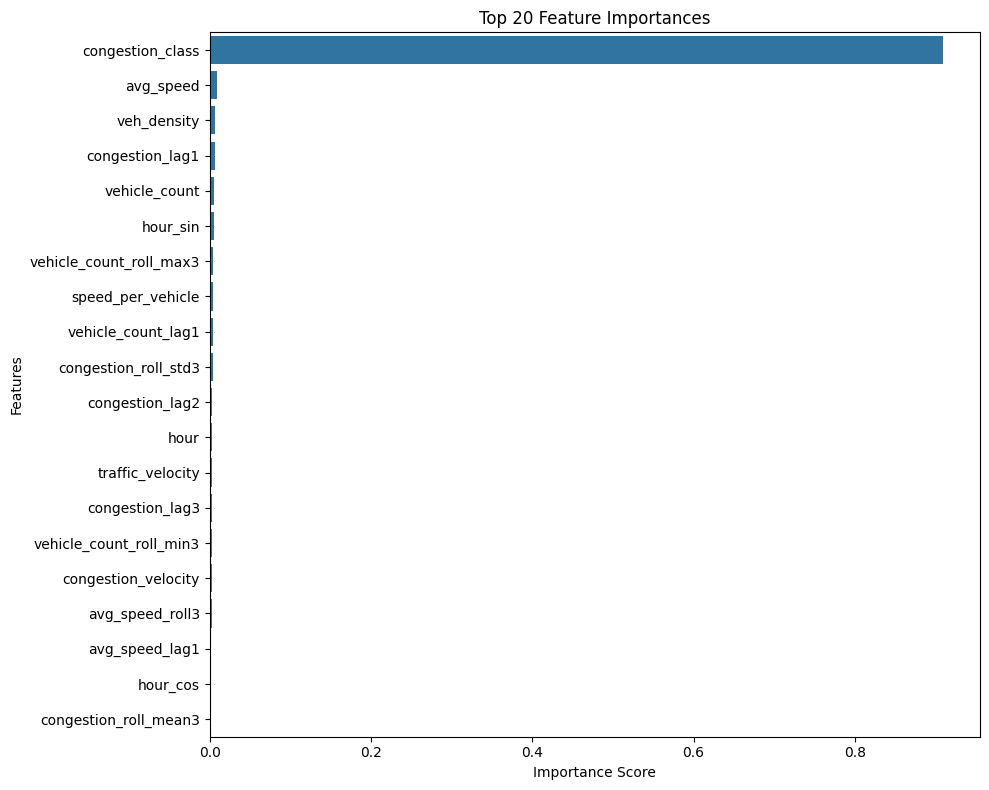

In [24]:
importances = pd.Series(rf_reg.feature_importances_, index=X.columns)
top_importances = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_importances.values, y=top_importances.index)
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [25]:
# --- Comparison of Model Performance ---
print("\n--- Performance Comparison Summary ---")
print("Metric         | Baseline Model | Engineered Features Model")
print("-------------------------------------------------------")
print(f"MAE            | {mae_baseline:.2f}          | {mae_engineered:.2f}")
print(f"MSE            | {mse_baseline:.2f}          | {mse_engineered:.2f}")
print(f"RMSE           | {rmse_baseline:.2f}          | {rmse_engineered:.2f}")
print(f"R2             | {r2_baseline:.2f}          | {r2_engineered:.2f}")



--- Performance Comparison Summary ---
Metric         | Baseline Model | Engineered Features Model
-------------------------------------------------------
MAE            | 1.26          | 0.48
MSE            | 2.17          | 0.28
RMSE           | 1.47          | 0.53
R2             | -0.07          | 0.91


In [26]:
# CROSS VALIDATION
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate

# loading our csv file with engineered features 
df_feat = pd.read_csv("df_feat.csv")

# Checking if target exists
if 'target_congestion_level' not in df_feat.columns:
    raise ValueError("Column 'target_congestion_level' is missing in df_feat!")

# Dropping rows with missing values 
df_feat = df_feat.dropna().reset_index(drop=True)

# Separating target and drop unused columns ---
y = df_feat['target_congestion_level']
df_feat = df_feat.drop(columns=['target_congestion_level', 'timestamp'], errors='ignore')

# Encoding categorical features 
for col in df_feat.select_dtypes(include=['object', 'category']).columns:
    df_feat[col] = df_feat[col].astype(str)

categorical_cols = df_feat.select_dtypes(include='object').columns.tolist()
df_model = pd.get_dummies(df_feat, columns=categorical_cols, drop_first=True)

X = df_model

# Defining a Random Forest model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Defining scoring metrics for cross-validation
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': 'r2'
}

# Performing 5-fold cross-validation
cv_results = cross_validate(rf_reg, X, y, cv=5, scoring=scoring, return_train_score=False)

# Calculating mean and std for each metric (negate MAE and MSE because sklearn returns negative values for errors)
mae_engineered = -np.mean(cv_results['test_MAE'])
mse_engineered = -np.mean(cv_results['test_MSE'])
rmse_engineered = np.sqrt(mse_engineered)
r2_engineered = np.mean(cv_results['test_R2'])

# Printing metrics separately (rounded to 4 decimal places)
print("\n--- Model Performance ---")
print("Mean Absolute Error (MAE):")
print(f"{mae_engineered:.4f}")

print("Mean Squared Error (MSE):")
print(f"{mse_engineered:.4f}")

print("Root Mean Squared Error (RMSE):")
print(f"{rmse_engineered:.4f}")

print("R-squared (R²):")
print(f"{r2_engineered:.4f}")



--- Model Performance ---
Mean Absolute Error (MAE):
0.4851
Mean Squared Error (MSE):
0.3246
Root Mean Squared Error (RMSE):
0.5697
R-squared (R²):
0.8306


In [27]:
import pickle
# Saving the model to a .pkl file
with open('rf_model_engineered.pkl', 'wb') as f:
    pickle.dump(rf_reg, f)

print("Model saved as 'rf_model_engineered.pkl'")


Model saved as 'rf_model_engineered.pkl'
